# Hair Loss Predictions
## Team 2 -  Geniya, Jen, Kevin, Toni, Andrey, & Caleb 

In [69]:
# Importing necessary dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [70]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [71]:
# Start Spark session
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DataFrame").getOrCreate()

In [72]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "Predict_Hair_Fall.csv"
spark.sparkContext.addFile(url)
hair_data_df = spark.read.csv(SparkFiles.get("Predict_Hair_Fall.csv"), sep=",", header=True)

# Show DataFrame
hair_data_df.show()

25/03/26 21:06:25 WARN SparkContext: The path Predict_Hair_Fall.csv has been added already. Overwriting of added paths is not supported in the current version.


+------+--------+----------------+--------------------+------------------------+-------------------------+--------+---+----------------------+---------------------+-------+------------+---------+
|    Id|Genetics|Hormonal Changes|  Medical Conditions|Medications & Treatments|Nutritional Deficiencies |  Stress|Age|Poor Hair Care Habits |Environmental Factors|Smoking|Weight Loss |Hair Loss|
+------+--------+----------------+--------------------+------------------------+-------------------------+--------+---+----------------------+---------------------+-------+------------+---------+
|133992|     Yes|              No|             No Data|                 No Data|     Magnesium deficiency|Moderate| 19|                   Yes|                  Yes|     No|          No|        0|
|148393|      No|              No|              Eczema|             Antibiotics|     Magnesium deficiency|    High| 43|                   Yes|                  Yes|     No|          No|        0|
|155074|      No|   

# Import and Clean the Data

In [73]:
# Convert to a Pandas DataFrame for processiong and cleaning
hair_data_pd_df = hair_data_df.toPandas().drop('Id', axis = 1 )
hair_data_pd_df.columns = hair_data_pd_df.columns.str.strip()
hair_data_pd_df.head()

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [74]:
# Convert Hair Loss and Age to numeric
hair_data_pd_df["Age"] = pd.to_numeric(hair_data_pd_df["Age"], errors='coerce')
hair_data_pd_df["Hair Loss"] = pd.to_numeric(hair_data_pd_df["Hair Loss"], errors='coerce')

In [75]:
# Copy of DF for Use in visuals
hair_data_copy = hair_data_pd_df.copy()
hair_data_copy.head()

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


# Visualizations Analysis | Binary

### Hair Loss by Genetics

<Figure size 1000x600 with 0 Axes>

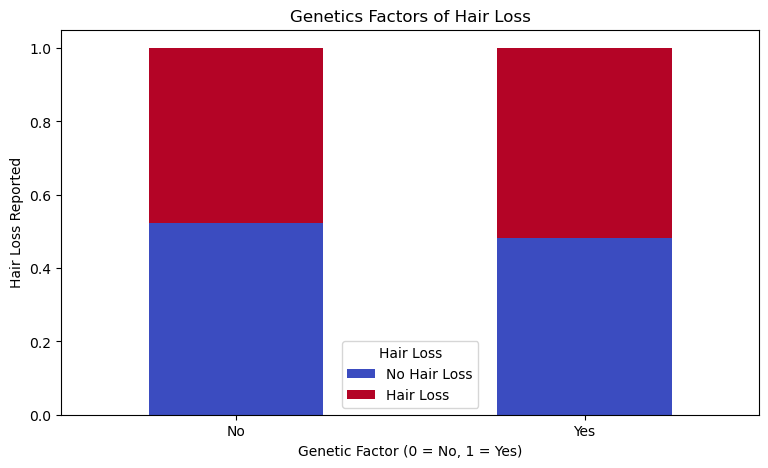

Hair Loss         0         1
Genetics                     
No         0.524109  0.475891
Yes        0.482759  0.517241


In [76]:
#Hair loss in people who do and don't carry the genetics for balding
genetics = hair_data_pd_df.groupby("Genetics")["Hair Loss"].value_counts(normalize=True).unstack()

# Create a chart
plt.figure(figsize=(10, 6))

genetics.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(9,5))
plt.title("Genetics Factors of Hair Loss")
plt.xlabel("Genetic Factor (0 = No, 1 = Yes)")
plt.ylabel("Hair Loss Reported")
plt.legend(title="Hair Loss", labels=["No Hair Loss", "Hair Loss"])
plt.xticks(rotation=0)
plt.show()

print(genetics)

### Hair Loss by Hormonal Changes

<Figure size 1000x600 with 0 Axes>

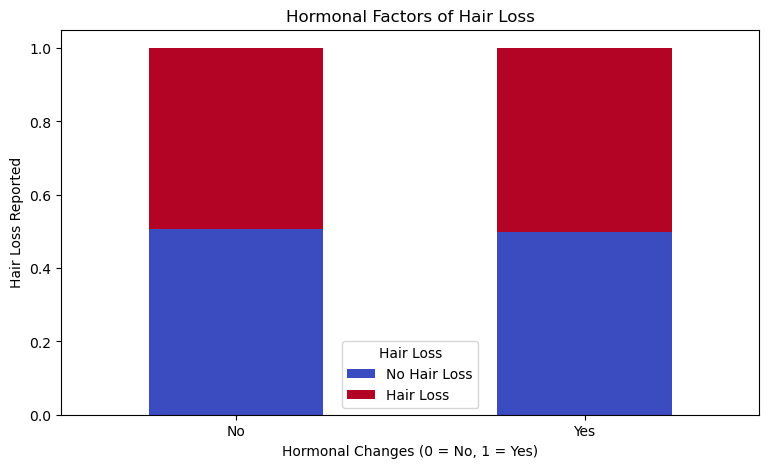

Hair Loss                0         1
Hormonal Changes                    
No                0.506122  0.493878
Yes               0.499018  0.500982


In [77]:
# Hair loss in people who have or haven't experience hormonal changes
hormonal = hair_data_pd_df.groupby("Hormonal Changes")["Hair Loss"].value_counts(normalize=True).unstack()

# Create a chart
plt.figure(figsize=(10, 6))

hormonal.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(9,5))
plt.title("Hormonal Factors of Hair Loss")
plt.xlabel("Hormonal Changes (0 = No, 1 = Yes)")
plt.ylabel("Hair Loss Reported")
plt.legend(title="Hair Loss", labels=["No Hair Loss", "Hair Loss"])
plt.xticks(rotation=0)
plt.show()

print(hormonal)

### Hair Loss and Poor Hair Care

<Figure size 1000x600 with 0 Axes>

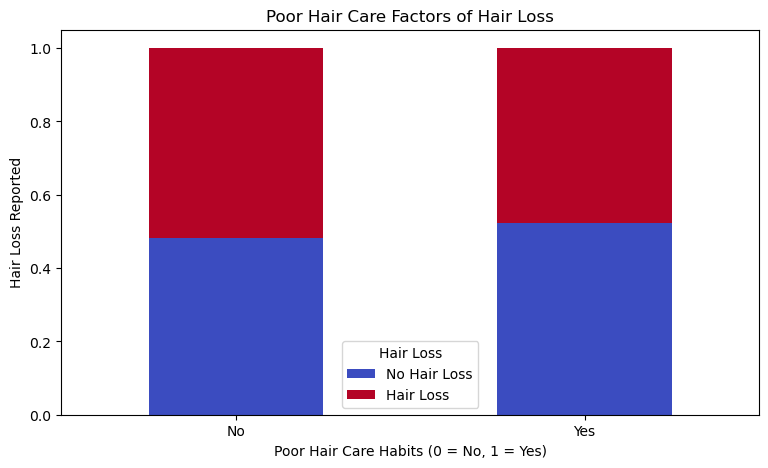

Hair Loss                     0         1
Poor Hair Care Habits                    
No                     0.483235  0.516765
Yes                    0.522358  0.477642


In [78]:
# Hair loss in people who have or don't have poor hair care habits
poor_hair_care = hair_data_pd_df.groupby("Poor Hair Care Habits")["Hair Loss"].value_counts(normalize=True).unstack()

# Create a chart
plt.figure(figsize=(10, 6))

poor_hair_care.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(9,5))
plt.title("Poor Hair Care Factors of Hair Loss")
plt.xlabel("Poor Hair Care Habits (0 = No, 1 = Yes)")
plt.ylabel("Hair Loss Reported")
plt.legend(title="Hair Loss", labels=["No Hair Loss", "Hair Loss"])
plt.xticks(rotation=0)
plt.show()

print(poor_hair_care)

### Comparison of Hair Loss by Smoking Status

<Figure size 800x500 with 0 Axes>

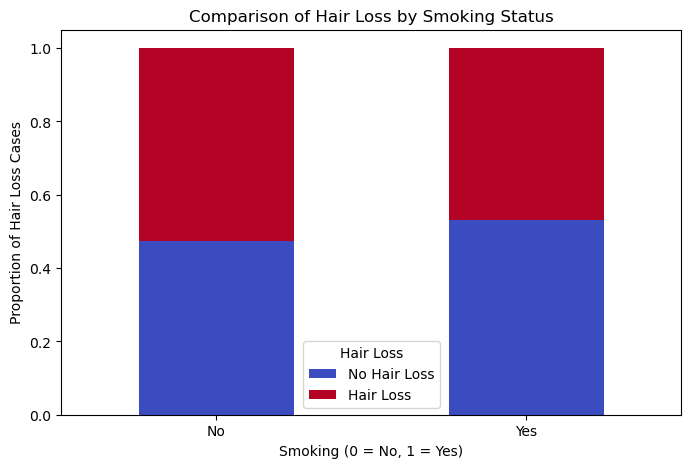

Hair Loss         0         1
Smoking                      
No         0.472917  0.527083
Yes        0.529865  0.470135


In [10]:
#Compute the percentage of hair loss occurrences for smokers vs non-smokers
smoking_hairloss = hair_data_pd_df.groupby("Smoking")["Hair Loss"].value_counts(normalize=True).unstack()

# Plot the relationship
plt.figure(figsize=(8, 5))
smoking_hairloss.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(8,5))
plt.title("Comparison of Hair Loss by Smoking Status")
plt.xlabel("Smoking (0 = No, 1 = Yes)")
plt.ylabel("Proportion of Hair Loss Cases")
plt.legend(title="Hair Loss", labels=["No Hair Loss", "Hair Loss"])
plt.xticks(rotation=0)
plt.show()

# Display numerical summary
print(smoking_hairloss)

### Comparison of Hair Loss by Weight Loss

<Figure size 800x500 with 0 Axes>

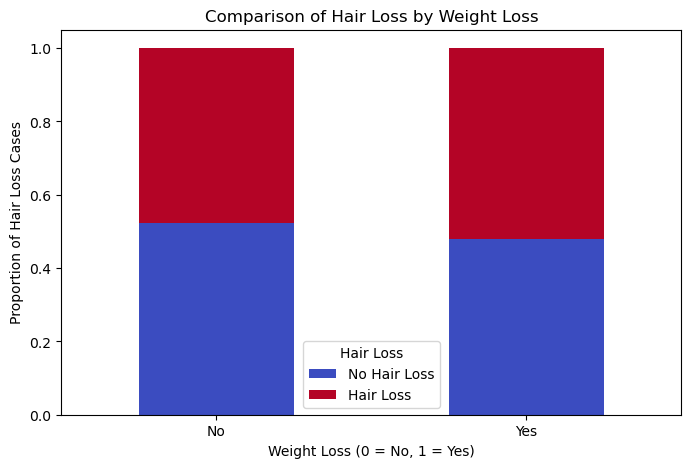

Hair Loss           0         1
Weight Loss                    
No           0.523719  0.476281
Yes          0.478814  0.521186


In [11]:
#Weight Loss by Age Group

#Compute the percentage of hair loss occurrences for Weight Loss vs No Weight Loss
Weight_Loss_hairloss = hair_data_pd_df.groupby("Weight Loss")["Hair Loss"].value_counts(normalize=True).unstack()

# Plot the relationship
plt.figure(figsize=(8, 5))
Weight_Loss_hairloss.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(8,5))
plt.title("Comparison of Hair Loss by Weight Loss")
plt.xlabel("Weight Loss (0 = No, 1 = Yes)")
plt.ylabel("Proportion of Hair Loss Cases")
plt.legend(title="Hair Loss", labels=["No Hair Loss", "Hair Loss"])
plt.xticks(rotation=0)
plt.show()

# Display numerical summary
print(Weight_Loss_hairloss)

### Comparison of Hair Loss by Environmental Factors by Age Group

<Figure size 800x500 with 0 Axes>

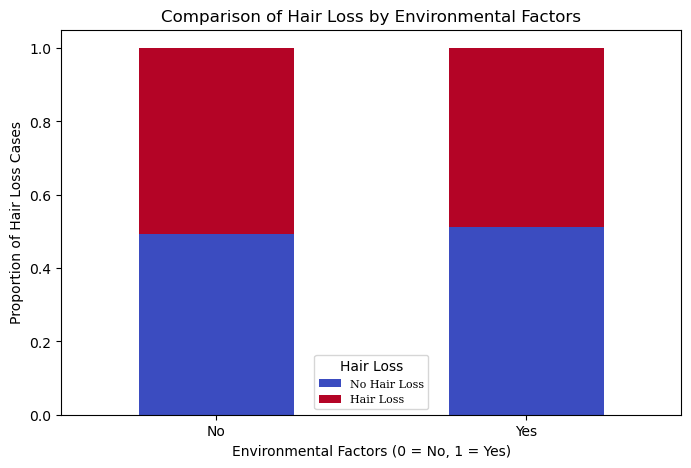

Hair Loss                     0         1
Environmental Factors                    
No                     0.492872  0.507128
Yes                    0.511811  0.488189


In [12]:
#WEnvironmental Factors by Age Group

#Compute the percentage of hair loss occurrences for Environmental Factors
Environmental_Factors_hairloss = hair_data_pd_df.groupby("Environmental Factors")["Hair Loss"].value_counts(normalize=True).unstack()

# Plot the relationship
plt.figure(figsize=(8, 5))
Environmental_Factors_hairloss.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(8,5))
plt.title("Comparison of Hair Loss by Environmental Factors")
plt.xlabel("Environmental Factors (0 = No, 1 = Yes)")
plt.ylabel("Proportion of Hair Loss Cases")
plt.legend(title="Hair Loss", labels=["No Hair Loss", "Hair Loss"],  prop={'family': 'serif', 'size': 8})
plt.xticks(rotation=0)
plt.show()

# Display numerical summary
print(Environmental_Factors_hairloss)

# Visualizations Analysis | Non-Binary

## Medical Conditions Pie Charts

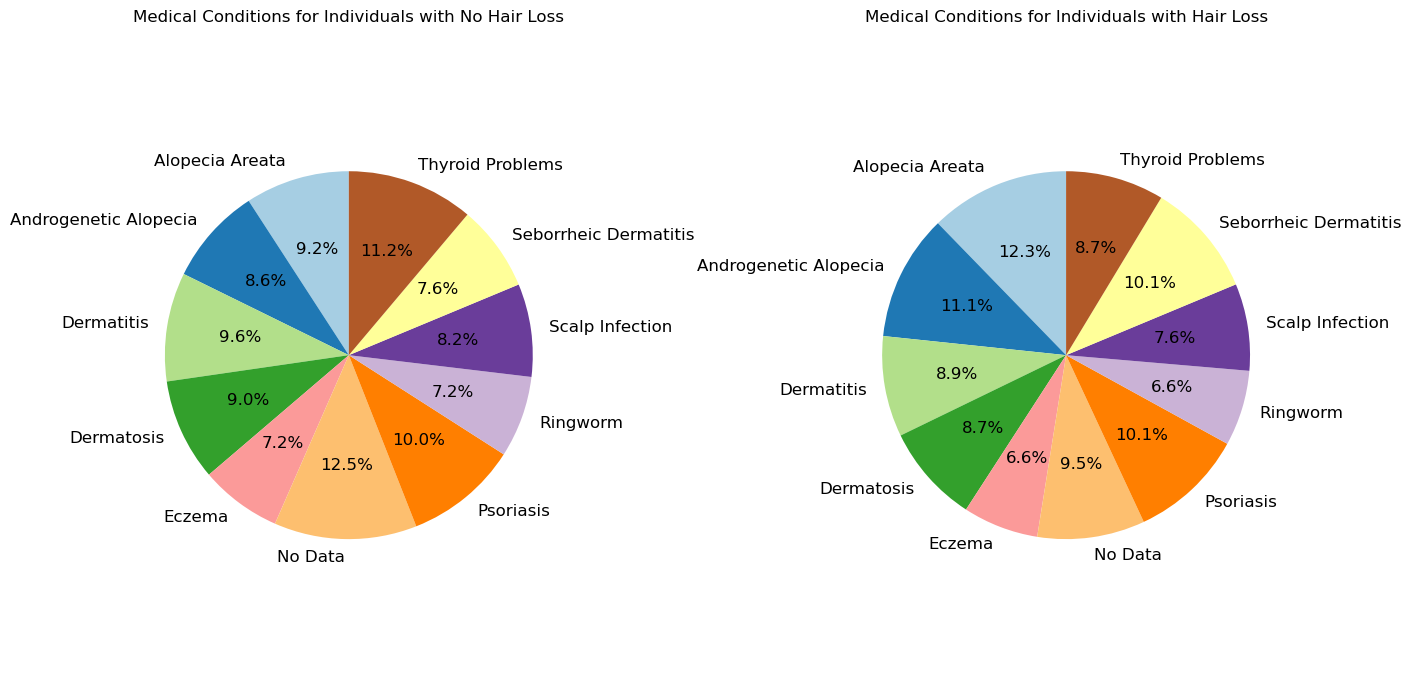

Hair Loss               0   1
Medical Conditions           
Alopecia Areata        46  61
Androgenetic Alopecia  43  55
Dermatitis             48  44
Dermatosis             45  43
Eczema                 36  33
No Data                63  47
Psoriasis              50  50
Ringworm               36  33
Scalp Infection        41  38
Seborrheic Dermatitis  38  50
Thyroid Problems       56  43


In [13]:
# Group medical condition data by Hair Loss column
medical_condition_counts = hair_data_pd_df.groupby(['Medical Conditions','Hair Loss']).size().unstack(fill_value=0)

# Medical Conditions Pie Chart
medical_conditions = medical_condition_counts.index
not_bald_counts = medical_condition_counts.apply(lambda x: x[0])
bald_counts = medical_condition_counts.apply(lambda x: x[1])

not_bald_counts = medical_condition_counts[0]
bald_counts = medical_condition_counts[1]

labels1 = medical_condition_counts.index
sizes1 = not_bald_counts
colors1 = plt.cm.Paired(np.linspace(0, 1, len(medical_condition_counts)))

labels2 = medical_condition_counts.index
sizes2 = bald_counts
colors2 = plt.cm.Paired(np.linspace(0, 1, len(medical_condition_counts)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90, colors=colors1, textprops={'fontsize': 12})
ax1.axis('equal')
ax1.set_title('Medical Conditions for Individuals with No Hair Loss')

ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90, colors=colors2, textprops={'fontsize': 12})
ax2.axis('equal')
ax2.set_title('Medical Conditions for Individuals with Hair Loss')

plt.tight_layout()
plt.show()

print(medical_condition_counts)

## Medications & Treatments Pie Charts

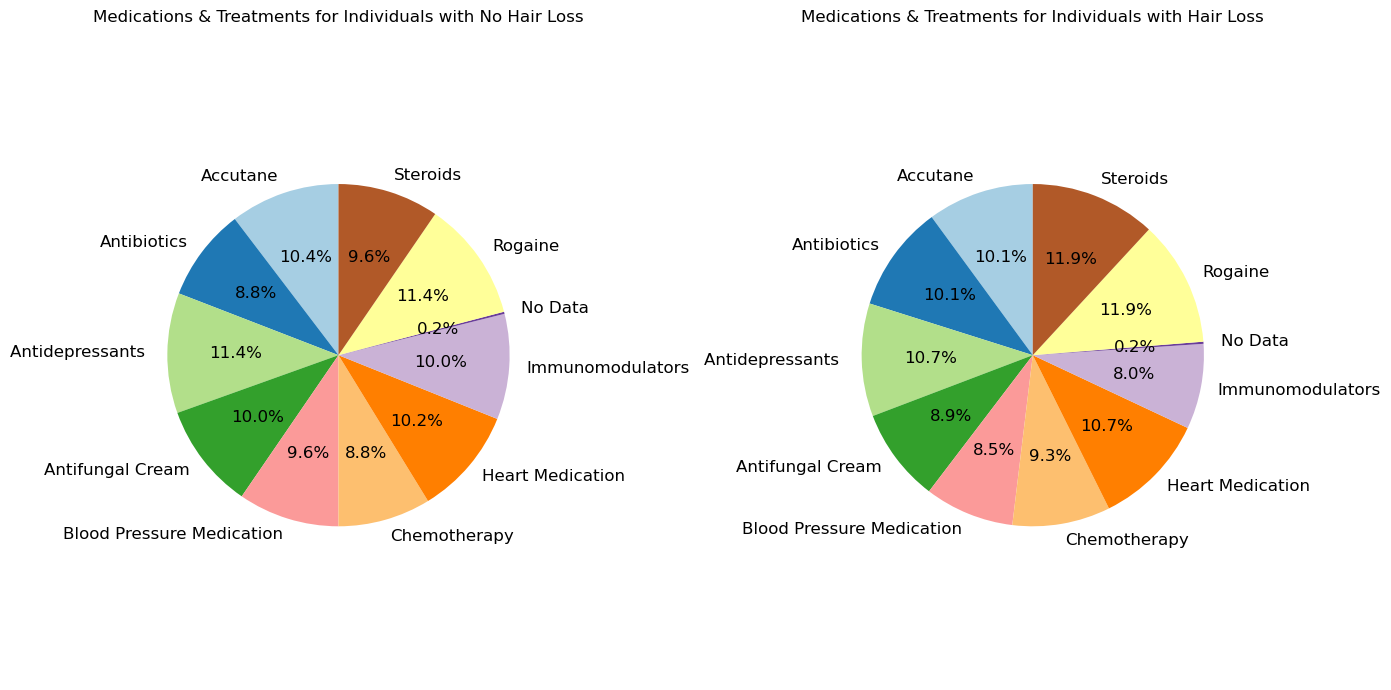

Hair Loss                   0   1
Medications & Treatments         
Accutane                   52  50
Antibiotics                44  50
Antidepressants            57  53
Antifungal Cream           50  44
Blood Pressure Medication  48  42
Chemotherapy               44  46
Heart Medication           51  53
Immunomodulators           50  40
No Data                     1   1
Rogaine                    57  59
Steroids                   48  59


In [14]:
# Group medications & treatments by Hair Loss column
medication_counts = hair_data_pd_df.groupby(['Medications & Treatments','Hair Loss']).size().unstack(fill_value=0)

# Medications & Treatments Pie Chart
medications = medication_counts.index
not_bald_counts = medication_counts.apply(lambda x: x[0])
bald_counts = medication_counts.apply(lambda x: x[1])

not_bald_counts = medication_counts[0]
bald_counts = medication_counts[1]

labels1 = medication_counts.index
sizes1 = not_bald_counts
colors1 = plt.cm.Paired(np.linspace(0, 1, len(medication_counts)))

labels2 = medication_counts.index
sizes2 = bald_counts
colors2 = plt.cm.Paired(np.linspace(0, 1, len(medication_counts)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90, colors=colors1, textprops={'fontsize': 12})
ax1.axis('equal')
ax1.set_title('Medications & Treatments for Individuals with No Hair Loss')

ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90, colors=colors2, textprops={'fontsize': 12})
ax2.axis('equal')
ax2.set_title('Medications & Treatments for Individuals with Hair Loss')

plt.tight_layout()
plt.show()

print(medication_counts)

## Nutritional Deficiencies Pie Charts

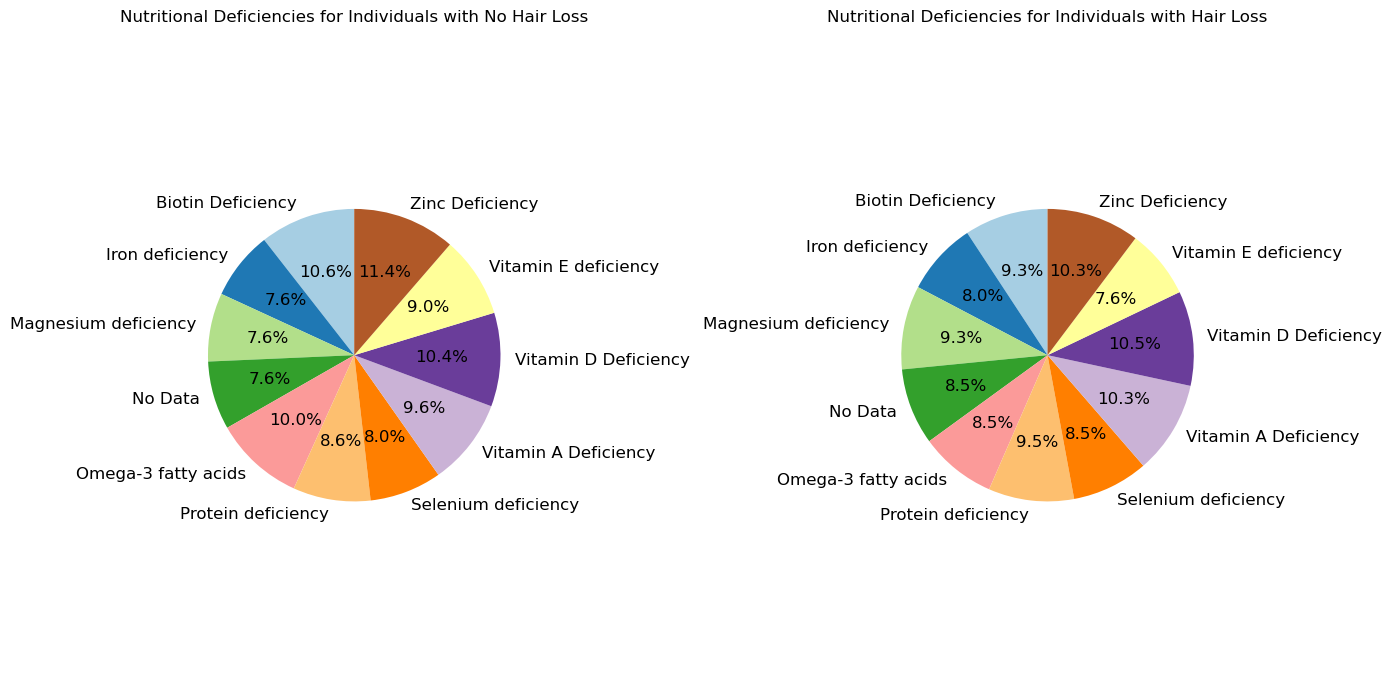

Hair Loss                  0   1
Nutritional Deficiencies        
Biotin Deficiency         53  46
Iron deficiency           38  40
Magnesium deficiency      38  46
No Data                   38  42
Omega-3 fatty acids       50  42
Protein deficiency        43  47
Selenium deficiency       40  42
Vitamin A Deficiency      48  51
Vitamin D Deficiency      52  52
Vitamin E deficiency      45  38
Zinc Deficiency           57  51


In [15]:
# Group Nutritional Deficiencies by Hair loss column
nutrition_counts = hair_data_pd_df.groupby(['Nutritional Deficiencies','Hair Loss']).size().unstack(fill_value=0)

# Nutritional Deficiencies Pie Chart
nutrition = nutrition_counts.index
not_bald_counts = nutrition_counts.apply(lambda x: x[0])
bald_counts = nutrition_counts.apply(lambda x: x[1])

not_bald_counts = nutrition_counts[0]
bald_counts = nutrition_counts[1]

labels1 = nutrition_counts.index
sizes1 = not_bald_counts
colors1 = plt.cm.Paired(np.linspace(0, 1, len(nutrition_counts)))

labels2 = nutrition_counts.index
sizes2 = bald_counts
colors2 = plt.cm.Paired(np.linspace(0, 1, len(nutrition_counts)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90, colors=colors1, textprops={'fontsize': 12})
ax1.axis('equal')
ax1.set_title('Nutritional Deficiencies for Individuals with No Hair Loss')

ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90, colors=colors2, textprops={'fontsize': 12})
ax2.axis('equal')
ax2.set_title('Nutritional Deficiencies for Individuals with Hair Loss')

plt.tight_layout()
plt.show()

print(nutrition_counts)

## Bar chart for stress levels

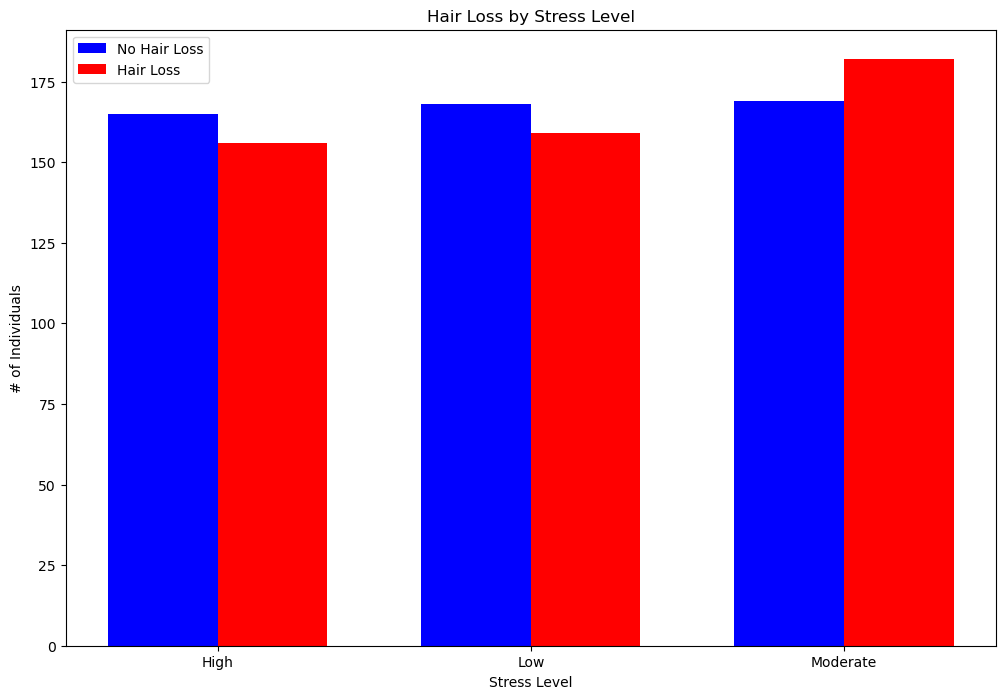

Hair Loss    0    1
Stress             
High       165  156
Low        168  159
Moderate   169  182


In [16]:
# Group stress levels by hair loss column
stress_counts = hair_data_pd_df.groupby(['Stress','Hair Loss']).size().unstack(fill_value=0)

# Bar chart for stress level
stress = stress_counts.index
bald_counts4 = stress_counts[1]
not_bald_counts4 = stress_counts[0]

x = np.arange(len(stress))
width = 0.35

fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.bar(x - width/2, not_bald_counts4, width, label='No Hair Loss', color='blue')
rects2 = ax.bar(x + width/2, bald_counts4, width, label='Hair Loss', color='red')


ax.set_xlabel('Stress Level')
ax.set_ylabel('# of Individuals')
ax.set_title('Hair Loss by Stress Level')
ax.set_xticks(x)
ax.set_xticklabels(stress)
ax.legend()

plt.show()

print(stress_counts)

## Age Groups

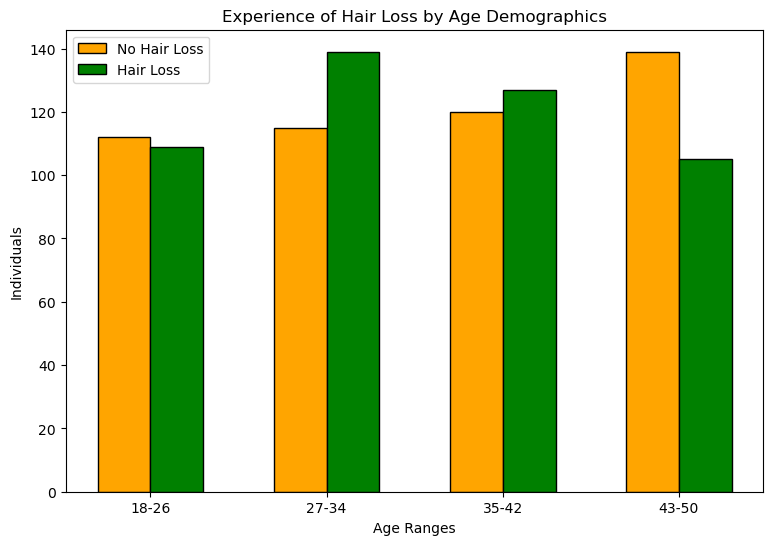

In [40]:
# Create the age demographics
bins = [18, 26, 34, 42, 50]
labels = ["18-26", "27-34", "35-42", "43-50"]
hair_data_copy["Age Demographics"] = pd.cut(hair_data_copy["Age"], bins=bins, labels=labels, right=True)

# Hair loss or lack there of based on age groups
age_demo_hair_loss = hair_data_copy.groupby(["Age Demographics", "Hair Loss"]).size().unstack(fill_value=0)

# Plot side-by-side bars
bar_width = 0.3
age_range = np.arange(len(labels))

plt.figure(figsize=(9, 6))

# Plot "No Hair Loss" bars
plt.bar(age_range - bar_width/2, age_demo_hair_loss[0], width=bar_width, label="No Hair Loss", color="orange", edgecolor="black")

# Plot "Hair Loss" bars
plt.bar(age_range + bar_width/2, age_demo_hair_loss[1], width=bar_width, label="Hair Loss", color="green", edgecolor="black")

# Labels and title
plt.title("Experience of Hair Loss by Age Demographics")
plt.xlabel("Age Ranges")
plt.ylabel("Individuals")
plt.xticks(ticks=age_range, labels=labels)
plt.legend()

# Show the plot
plt.show()

## Histogram of Age

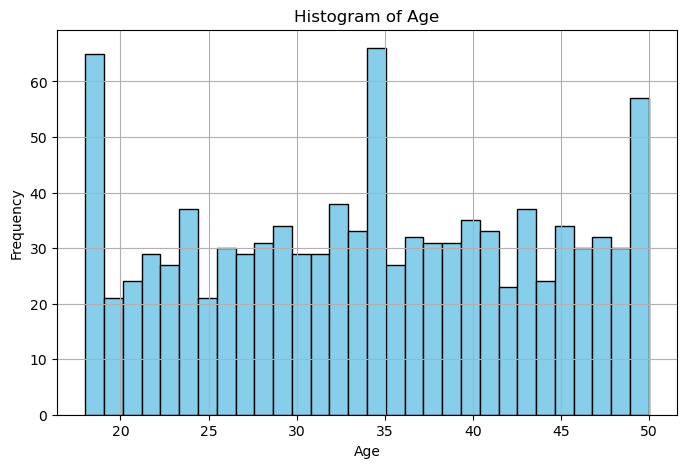

In [42]:
# Create histogram for the Age column
plt.figure(figsize=(8, 5))
hair_data_pd_df["Age"].hist(bins=30, color="skyblue", edgecolor="black")

# Titles and labels
plt.title("Histogram of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")

# The x-axis (Age) is divided into 30 bins (intervals).
# The y-axis (Frequency) shows how many data points (people) fall within each age range.
# Each bar height represents the count (or frequency) of people whose age falls within that specific bin.

# Show the plot
plt.show()

## Standardizing the Data

In [44]:
# Create get_dummies 
hair_data_dummies = pd.get_dummies(hair_data_pd_df)
hair_data_dummies.head()

,Age,Hair Loss,Genetics_No,Genetics_Yes,Hormonal Changes_No,Hormonal Changes_Yes,Medical Conditions_Alopecia Areata,Medical Conditions_Androgenetic Alopecia,Medical Conditions_Dermatitis,Medical Conditions_Dermatosis,...,Stress_Low,Stress_Moderate,Poor Hair Care Habits_No,Poor Hair Care Habits_Yes,Environmental Factors_No,Environmental Factors_Yes,Smoking_No,Smoking_Yes,Weight Loss_No,Weight Loss_Yes
0,19,0,False,True,True,False,False,False,False,False,...,False,True,False,True,False,True,True,False,True,False
1,43,0,True,False,True,False,False,False,False,False,...,False,False,False,True,False,True,True,False,True,False
2,26,0,True,False,True,False,False,False,False,True,...,False,True,False,True,False,True,True,False,False,True
3,46,0,False,True,False,True,False,False,False,False,...,False,True,False,True,False,True,True,False,True,False
4,30,1,True,False,True,False,False,False,False,False,...,False,True,True,False,False,True,False,True,True,False


In [45]:
# Assign X and y variables
y = hair_data_pd_df['Hair Loss'].ravel()
X = hair_data_dummies.drop('Hair Loss', axis = 1)

In [46]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [47]:
#Intialize scaler
X_scaler = MinMaxScaler() #Explain why minmax and not standard

#Fitting the scaler
X_scaler = X_scaler.fit(X_train)

#Fit scaler on training set and testing set
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [48]:
# Build Random Forest Model
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

rf_model = rf_model.fit(X_train, y_train)

prediction = rf_model.predict(X_test)

## Model Evaluation

In [49]:
# Display Model Evaluation
cm = confusion_matrix(y_test, prediction)
print("Confusion Matrix")
print(cm)

print("Classification Report")
print(classification_report(y_test, prediction))

Confusion Matrix
[[72 55]
 [58 65]]
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       127
           1       0.54      0.53      0.53       123

    accuracy                           0.55       250
   macro avg       0.55      0.55      0.55       250
weighted avg       0.55      0.55      0.55       250



In [50]:
# Build Random Forest Model
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

rf_model = rf_model.fit(X_train, y_train)

prediction = rf_model.predict(X_train)

In [51]:
# Display Model Evaluation
cm = confusion_matrix(y_train, prediction)
print("Confusion Matrix")
print(cm)

print("Classification Report")
print(classification_report(y_train, prediction))

Confusion Matrix
[[375   0]
 [  0 374]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00       374

    accuracy                           1.00       749
   macro avg       1.00      1.00      1.00       749
weighted avg       1.00      1.00      1.00       749



# Optimizing the Model

In [52]:
hair_data_dummies_2 = pd.get_dummies(hair_data_pd_df, drop_first=True) # Useful when preventing multicollinearity in regression models.
hair_data_dummies_2.head()

,Age,Hair Loss,Genetics_Yes,Hormonal Changes_Yes,Medical Conditions_Androgenetic Alopecia,Medical Conditions_Dermatitis,Medical Conditions_Dermatosis,Medical Conditions_Eczema,Medical Conditions_No Data,Medical Conditions_Psoriasis,...,Nutritional Deficiencies_Vitamin A Deficiency,Nutritional Deficiencies_Vitamin D Deficiency,Nutritional Deficiencies_Vitamin E deficiency,Nutritional Deficiencies_Zinc Deficiency,Stress_Low,Stress_Moderate,Poor Hair Care Habits_Yes,Environmental Factors_Yes,Smoking_Yes,Weight Loss_Yes
0,19,0,True,False,False,False,False,False,True,False,...,False,False,False,False,False,True,True,True,False,False
1,43,0,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,True,False,False
2,26,0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,True,True,True,False,True
3,46,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False
4,30,1,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,True,True,False


In [53]:
y = hair_data_pd_df['Hair Loss'].ravel()
X = hair_data_dummies_2.drop('Hair Loss', axis = 1)

In [54]:
# Splitting into Train and Test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, random_state=78)

In [55]:
#Intialize scaler
X_scaler = MinMaxScaler() # Scale the data to a specific range and when the data does not contain outliers

#Fitting the scaler
X_scaler = X_scaler.fit(X_train_2)

#Fit scaler on training set and testing set
X_train_scaled_2 = X_scaler.transform(X_train_2)
X_test_scaled_2 = X_scaler.transform(X_test_2)

In [56]:
# Build Random Forest Model
rf_model = RandomForestClassifier(n_estimators=150, random_state=78) #Lowering number of n_estimators

rf_model = rf_model.fit(X_train_2, y_train_2)

prediction = rf_model.predict(X_test_2)

In [57]:
# Display Model Evaluation
cm = confusion_matrix(y_test_2, prediction)
print("Confusion Matrix")
print(cm)

print("Classification Report")
print(classification_report(y_test_2, prediction))

Confusion Matrix
[[76 51]
 [55 68]]
Classification Report
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       127
           1       0.57      0.55      0.56       123

    accuracy                           0.58       250
   macro avg       0.58      0.58      0.58       250
weighted avg       0.58      0.58      0.58       250



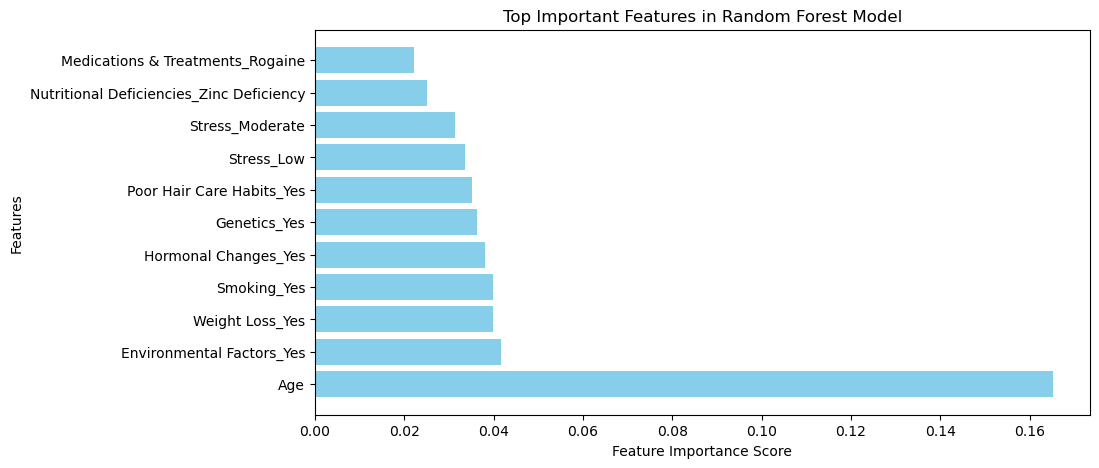

In [68]:
# Feature Importance Plot 
feature_importance = rf_model.feature_importances_

# Create a DataFrame for better manipulation
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance and select the top 11 features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(11)

# Plotting
plt.figure(figsize=(10, 5))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top Important Features in Random Forest Model")
plt.show()